### Exercise rf table, model space, and prediction menu code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu

%matplotlib inline  
%load_ext autoreload
%autoreload 2


Using gpu device 0: GeForce GTX TITAN X


#### create an rf table

In [2]:
rf_table = make_rf_table(20, (.5, 2, 5), 2., pix_per_stim=3)
rf_table.shape

(500, 6)

In [3]:
rf_table.head()

,deg_per_radius,x_deg,y_deg,pix_per_radius,x_pix,y_pix
0,0.5,-10.000000,-10,0.075,-1.500000,-1.5
1,0.5,-7.777778,-10,0.075,-1.166667,-1.5
2,0.5,-5.555556,-10,0.075,-0.833333,-1.5
3,0.5,-3.333333,-10,0.075,-0.500000,-1.5
4,0.5,-1.111111,-10,0.075,-0.166667,-1.5


In [4]:
rf_table.tail()

,deg_per_radius,x_deg,y_deg,pix_per_radius,x_pix,y_pix
495,2,1.111111,10,0.3,0.166667,1.5
496,2,3.333333,10,0.3,0.500000,1.5
497,2,5.555556,10,0.3,0.833333,1.5
498,2,7.777778,10,0.3,1.166667,1.5
499,2,10.000000,10,0.3,1.500000,1.5


/home/tnaselar/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


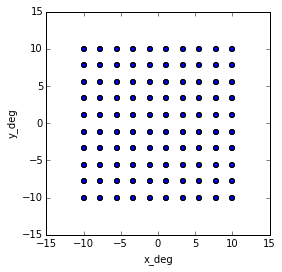

In [5]:
ax = rf_table.plot(x='x_deg',y='y_deg',kind='scatter',)
ax.set_aspect('equal')

#### instantiate a receptive_fields object

In [6]:
rf = receptive_fields(20,(.5, 7,8),.5)

In [7]:
rf.rf_table.shape[0]

12800

In [8]:
##the total number of rf models (# sizes x # locations)
rf.G

12800

In [9]:
##generate rf model filters (pictures of gaussian blobs) at desired resolution.
##note that not all rf's will survive at all resolutions. we print a message in this case and return 0's
rf_stack = rf.make_rf_stack(8,min_pix_per_radius=1)

at pixel resolution 8 the following rfs will default to 0: (array([ 0.5       ,  1.42857143,  2.35714286]),)


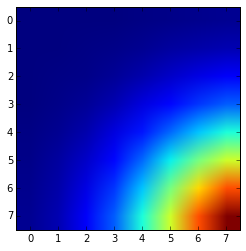

In [10]:
plt.imshow(rf_stack[-1,:,:])

#### construct a model space

In [11]:
T = 14
fd = {}
D = [1,2,3,4]
S = [10,20,30,40]
names = ['a','b','c','d']
for i,n in enumerate(names):
    fd[n] = np.random.rand(T,D[i],S[i],S[i]).astype('float32')
ms = model_space(fd,rf,add_bias=True)

In [12]:
print ms.D
print ms.feature_depth
print ms.feature_indices
print ms.feature_depth.keys()

11
{'a': 1, 'c': 3, 'b': 2, 'bias': 1, 'd': 4}
{'a': array([0]), 'c': array([1, 2, 3]), 'b': array([4, 5]), 'bias': -1, 'd': array([6, 7, 8, 9])}
['a', 'c', 'b', 'bias', 'd']


##### the logic of normalization.
By default, we normalize all model_space_tensors. However, the model_space object will complain until you 
have explicitly saved a set of normalization constants. So, you have identify what you consider to be the
"training data", generate a model_space_tensor from this data with "normalize=False", then 
normalize the resulting mst with "save=True".

After that, any additional mst's generated by by the model_space object will be normalized using the saved
means and standard deviations.

In [13]:
##this will fail because it will try to apply normalization by default, but we haven't 
##saved any normalization constants yet
mst = ms.construct_model_space_tensor(fd)


at pixel resolution 10 the following rfs will default to 0: (array([ 0.5       ,  1.42857143]),)
at pixel resolution 30 the following rfs will default to 0: (array([ 0.5]),)
at pixel resolution 20 the following rfs will default to 0: (array([ 0.5]),)


Exception: if you want to compute the mean and stdev from the current data, you have to commit to saving it as an attribute

In [14]:
##so we first generate an unormalized model_space_tensor
mst = ms.construct_model_space_tensor(fd,normalize=False)

##then we explicitly normalize it and save the normalization constants (i.e., the mean and stdev.)
mst = ms.normalize_model_space_tensor(mst,save=True)


at pixel resolution 10 the following rfs will default to 0: (array([ 0.5       ,  1.42857143]),)
at pixel resolution 30 the following rfs will default to 0: (array([ 0.5]),)
at pixel resolution 20 the following rfs will default to 0: (array([ 0.5]),)
normalization constants have been saved
model_space_tensor has been z-scored


In [15]:
##now we pass feature maps of a different set of stimuli and the saved normlztn. constants
##will be applied by default when we construct a new model_space_tensor
T = 14
new_fd = {}
for i,n in enumerate(names):
    new_fd[n] = np.random.rand(T,D[i],S[i],S[i]).astype('float32')

new_mst = ms.construct_model_space_tensor(new_fd)

at pixel resolution 10 the following rfs will default to 0: (array([ 0.5       ,  1.42857143]),)
at pixel resolution 30 the following rfs will default to 0: (array([ 0.5]),)
at pixel resolution 20 the following rfs will default to 0: (array([ 0.5]),)
model_space_tensor has been z-scored


#### create prediction menus given the model space and some feature weights

In [16]:
V = 50 ##number of voxels
feature_weights = np.random.rand(ms.receptive_fields.G, ms.D, V).astype('float32')

In [17]:
print mst.shape
print feature_weights.shape

(12800, 14, 11)
(12800, 11, 50)


In [18]:
##initially we have feature weights for each voxel for each potential rf model
pmt = prediction_menu(mst.astype('float32'), feature_weights)
print pmt.shape

(12800, 14, 50)


In [19]:
##after some traning, we've identified the best rf model for each voxel and stored the corresponding feature_weights
best_feature_weights = np.zeros((ms.D,V))
best_rfs = np.random.randint(0,high=ms.receptive_fields.G,size=V)
for v in range(V):
    best_feature_weights[:,v] = feature_weights[best_rfs[v],:,v]
best_feature_weights = best_feature_weights.astype('float32')

In [20]:
##we can then pass only the best feature weights and the indices for the best rfs
best_pmt = prediction_menu(mst, best_feature_weights[np.newaxis,:,:], rf_indices=best_rfs)

/musc.repo/Docs/tnaselar/code/Python/hrf_fitting/src/feature_weighted_rf_models.py:332: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if rf_indices != None:


In [21]:
##and get predictions for only the best model for each voxel
best_pmt.shape  ##= Time x Voxel

(14, 50)

In [ ]:
##we can then go back use the model_space object to see 